In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

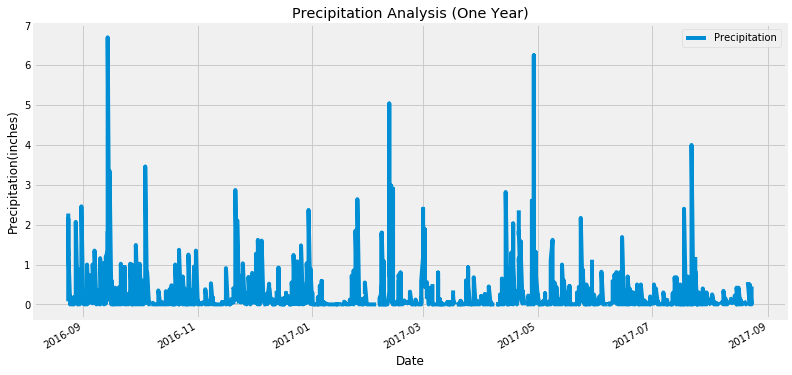

In [11]:
# Retrieve the last 12 months of precipitation data
year_prec = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > '2016-08-23').\
                        order_by(Measurement.date).all()

precipitation_df = pd.DataFrame(year_prec, columns=['Date', 'Prcp'])
# Change the date to a datetime format.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

#Reset the index to the 'Date'
precipitation_df.set_index(precipitation_df['Date'], inplace=True)
precipitation_df.head()

# Plot the dataframe as a horizontal bar chart using pandas plotting

precipitation_df.plot('Date', 'Prcp',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (One Year)")
plt.legend(["Precipitation"])
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe()


,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count


9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Count = func.count(Measurement.tobs).label("Count")
station_list = session.query(Measurement.station, func.count(Measurement.tobs).label("Count")).\
group_by(Measurement.station).order_by(Count.desc())

for sl in station_list:
    print(f"Station:{sl[0]}\tCount:{sl[1]}")


Station:USC00519281	Count:2772
Station:USC00519397	Count:2724
Station:USC00513117	Count:2709
Station:USC00519523	Count:2669
Station:USC00516128	Count:2612
Station:USC00514830	Count:2202
Station:USC00511918	Count:1979
Station:USC00517948	Count:1372
Station:USC00518838	Count:511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281")
print(temp_data[0])

(54.0, 85.0, 71.66378066378067)


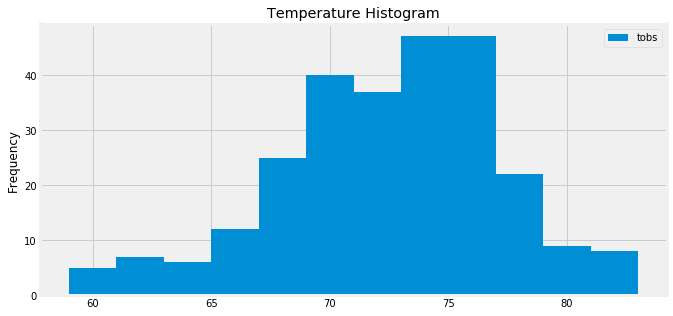

<Figure size 432x288 with 0 Axes>

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>last_to_last_yr).\
                filter(Measurement.station == "USC00519281")
result_temp_df = pd.DataFrame(result_temp[:],columns=['Date','TempObs'])
result_temp_df.head()

plt.figure(figsize=(10,5))
plt.hist(result_temp_df["TempObs"], bins=12, label='tobs')
plt.ylabel("Frequency")
plt.title("Temperature Histogram")
plt.legend()
plt.show()
plt.savefig("Images/Temperature_Histogram.png")

![precipitation](Images/station-histogram.png)

In [22]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    for Tmin, Tmax, Tavg in query:
        print("the minimum is",
              Tmin,'\u00b0'"F, the avg is", "{0:.1f}".format(round(Tavg,1)),'\u00b0'"F, the maximum is",
              "{0:.1f}".format(round(Tmax,1)),'\u00b0'"F.")

calc_temps('2017-06-28', '2017-07-07')

the minimum is 74.0 °F, the avg is 77.7 °F, the maximum is 87.0 °F.


In [23]:
start_date = '2017-06-28'
end_date = '2017-07-07'
vacay_query = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# Load the results into a pandas dataframe.

vacay_temps = pd.DataFrame(vacay_query, columns=['Date', 'Tobs'])
vacay_temps.head()

,Date,Tobs
0,2017-06-28,79.0
1,2017-06-29,79.0
2,2017-06-30,75.0
3,2017-07-01,80.0
4,2017-07-02,80.0


In [24]:
avg_temp = vacay_temps.mean()
temp_diff = (vacay_temps["Tobs"].max()-vacay_temps["Tobs"].min())
temp_diff

13.0

In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-06-28','2017-07-07')
print(trip_temp)

the minimum is 74.0 °F, the avg is 77.7 °F, the maximum is 87.0 °F.
None


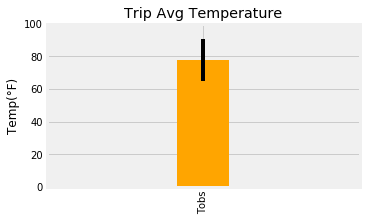

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = vacay_temps.mean()
temp_diff = (vacay_temps["Tobs"].max()-vacay_temps["Tobs"].min())


p = avg_temp.plot(legend=False,kind="bar",color="orange",yerr=temp_diff, width=0.1, figsize=(5,3))
p.set_title("Trip Avg Temperature")
p.set_ylabel("Temp(°F)")
p.set_ylim(0,100)
plt.show()


In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Rainfall = func.avg(Measurement.prcp).label("Rainfall")
ly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation, \
                            func.avg(Measurement.prcp).label("Rainfall")).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= '2011-02-28').\
                filter(Measurement.date <= '2011-03-05').group_by(Measurement.station).order_by(Rainfall.desc())


index = 0
for rf in ly_rainfall:
    print(ly_rainfall[index])
    index = index + 1

('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.5825)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.392)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.37166666666666665)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.365)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.24166666666666667)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22999999999999998)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.126)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
